<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/NAT_FP_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install colab-env --upgrade -q
import colab_env
!pip install uv -q

In [ ]:
!uv pip install "nvidia-nat[all]"

In [3]:
!pip install avwx-engine -q

In [9]:
!nvidia-smi

Wed Jan 14 00:32:43 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   31C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----


[AC-101] CLEARED
**Technical Bulletin: AC-101**

**Flight Information:**

- Flight Number: AC-101
- Decision: CLEARED
- Fuel: 177,000 kg

**METAR Interpretation:**

METAR VTBS 132330Z VRB01KT 8000 NSC 22/17 Q1013 NOSIG

- **Date/Time:** 132330Z (13:23:00 UTC)
- **Location:** VTBS (Suvarnabhumi Airport, Bangkok, Thailand)
- **Wind:** VRB (Variable direction) 01KT (1 knot)
- **Visibility:** 8000 meters (8 km)
- **Clouds:** NSC (No significant clouds)
- **Temperature:** 22°C
- **Dew Point:** 17°C
- **Pressure:** Q1013 (1013 hPa)
- **Remarks:** NOSIG (No significant changes)

**Flight Dispatch Decision:**

Based on the METAR data, the flight is CLEARED for departure. The weather conditions at Suvarnabhumi Airport are nominal, with a variable wind direction at 1 knot, good visibility, and no significant clouds. The temperature and dew point are within acceptable limits. The pressure is also within normal limits.

**Recommendations:**

- Monitor weather conditions en route and at destinatio

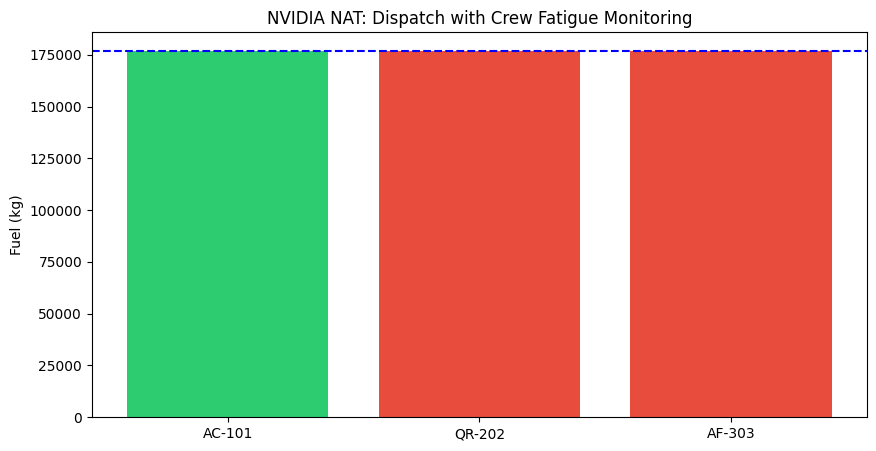

In [8]:
import asyncio
import os
import getpass
import avwx  # Live aviation weather engine
from openai import AsyncOpenAI
import nest_asyncio
import matplotlib.pyplot as plt
from pydantic import Field
from tenacity import retry, stop_after_attempt, wait_exponential

# Required for execution in async environments like Jupyter
nest_asyncio.apply()

from nat.cli.register_workflow import register_function
from nat.data_models.function import FunctionBaseConfig
from nat.cli.type_registry import GlobalTypeRegistry

# --- 1. System Setup ---
try:
    GlobalTypeRegistry.get()._registered_functions.clear()
except Exception:
    pass

if "NVIDIA_API_KEY" not in os.environ:
    os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter NVIDIA API Key: ")

client = AsyncOpenAI(
    base_url="https://integrate.api.nvidia.com/v1",
    api_key=os.environ["NVIDIA_API_KEY"]
)

# --- 2. Data Models (Strict Typing) ---
class RouteWeatherInput(FunctionBaseConfig, name="route_weather"):
    icao_code: str = Field(..., description="Destination ICAO code (e.g., VTBS)")

class DocumentInput(FunctionBaseConfig, name="doc_check"):
    passport_valid_months: int = Field(...)
    has_tdac: bool = Field(default=False)

class MaintenanceInput(FunctionBaseConfig, name="maintenance_check"):
    aircraft_id: str = Field(...)
    hours_since_last_service: int = Field(...)
    has_unresolved_mel: bool = Field(default=False)

class CrewFatigueInput(FunctionBaseConfig, name="crew_fatigue"):
    duty_hours: float = Field(..., description="Current hours on duty")
    rest_period_hours: float = Field(..., description="Hours of rest since last duty")
    crew_id: str = Field(...)

class FuelDynamicsInput(FunctionBaseConfig, name="fuel_dynamics"):
    base_load: float = Field(default=177000.0)
    is_rerouted: bool = Field(default=False)

class BriefingTemplateInput(FunctionBaseConfig, name="briefing_template"):
    id: str = Field(...)
    decision: str = Field(...)
    reason: str = Field(...)
    planned_fuel: float = Field(...)
    maint_status: str = Field(...)
    metar_raw: str = Field(default="N/A")

# --- 3. Specialized Agents ---

@register_function(config_type=RouteWeatherInput)
async def register_live_weather(config, builder):
    async def logic(input_data):
        try:
            metar = avwx.Metar(input_data.icao_code)
            await asyncio.to_thread(metar.update)
            is_severe = metar.data.flight_rules in ["IFR", "LIFR"]
            return {"condition": "SEVERE" if is_severe else "CLEAR",
                    "rules": metar.data.flight_rules, "raw": metar.raw}
        except Exception as e:
            return {"condition": "UNKNOWN", "raw": f"No METAR available: {str(e)}"}
    yield logic

@register_function(config_type=DocumentInput)
async def register_docs(config, builder):
    async def logic(input_data):
        valid = input_data.passport_valid_months >= 6 and input_data.has_tdac
        return {"valid": valid, "error": "Compliance failure: Documents Expired/Missing"}
    yield logic

@register_function(config_type=MaintenanceInput)
async def register_maintenance(config, builder):
    async def logic(input_data):
        airworthy = input_data.hours_since_last_service < 500 and not input_data.has_unresolved_mel
        return {"status": "AIRWORTHY" if airworthy else "AOG", "is_safe": airworthy}
    yield logic

@register_function(config_type=CrewFatigueInput)
async def register_crew_check(config, builder):
    async def logic(input_data):
        # Safety limit: max 12h duty, min 10h rest
        is_fit = input_data.duty_hours <= 12.0 and input_data.rest_period_hours >= 10.0
        return {"is_fit": is_fit, "status": "FIT" if is_fit else "FATIGUED"}
    yield logic

@register_function(config_type=FuelDynamicsInput)
async def register_fuel(config, builder):
    async def logic(input_data):
        total = input_data.base_load + (8000 if input_data.is_rerouted else 0)
        return {"total": total}
    yield logic

@register_function(config_type=BriefingTemplateInput)
async def register_briefing(config, builder):
    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
    async def logic(input_data):
        system_msg = ("You are a Senior Flight Dispatcher. Generate a technical bulletin. "
                      "Interpret METAR data. If REJECTED, state why (Maint, Docs, or Crew) "
                      "and do NOT suggest re-routing.")
        user_msg = (f"Flight: {input_data.id}, Decision: {input_data.decision}, "
                    f"Fuel: {input_data.planned_fuel}kg, Maintenance: {input_data.maint_status}, "
                    f"METAR: {input_data.metar_raw}, Reason: {input_data.reason}")
        resp = await client.chat.completions.create(
            model="meta/llama-3.1-8b-instruct",
            messages=[{"role": "system", "content": system_msg}, {"role": "user", "content": user_msg}],
            temperature=0.1
        )
        return {"report": resp.choices[0].message.content}
    yield logic

# --- 4. Orchestration ---

async def run_dispatch(flight_id, icao, pass_mo, tdac, hrs, mel, duty, rest):
    async with register_live_weather(None, None) as weather_agent, \
               register_docs(None, None) as doc_agent, \
               register_maintenance(None, None) as maint_agent, \
               register_crew_check(None, None) as crew_agent, \
               register_fuel(None, None) as fuel_agent, \
               register_briefing(None, None) as briefing_agent:

        # Step 1: Run core checks in parallel
        w, d, m, c = await asyncio.gather(
            weather_agent(RouteWeatherInput(icao_code=icao)),
            doc_agent(DocumentInput(passport_valid_months=pass_mo, has_tdac=tdac)),
            maint_agent(MaintenanceInput(aircraft_id=flight_id, hours_since_last_service=hrs, has_unresolved_mel=mel)),
            crew_agent(CrewFatigueInput(crew_id="CREW-X", duty_hours=duty, rest_period_hours=rest))
        )

        # Step 2: Decision Hierarchy
        reroute = False
        if not m["is_safe"]:
            decision, reason = "REJECTED", f"AOG: Maintenance overdue ({hrs} hrs)"
        elif not c["is_fit"]:
            decision, reason = "REJECTED", f"Crew Fatigue: Duty cycle limit reached"
        elif not d["valid"]:
            decision, reason = "REJECTED", "Document Compliance Failure"
        elif w["condition"] == "SEVERE":
            decision, reason = "RE-ROUTE", f"Weather minima: {w.get('rules', 'Unknown')}"
            reroute = True
        else:
            decision, reason = "CLEARED", "Nominal parameters"

        # Step 3: Finalize
        f = await fuel_agent(FuelDynamicsInput(is_rerouted=reroute))
        try:
            rpt = await briefing_agent(BriefingTemplateInput(
                id=flight_id, decision=decision, reason=reason,
                planned_fuel=f["total"], maint_status=m["status"], metar_raw=w["raw"]
            ))
            report_body = rpt["report"]
        except Exception as e:
            report_body = f"Briefing Unavailable: {str(e)}"

        return {"id": flight_id, "status": decision, "fuel": f["total"], "report": report_body}

def plot_log(results):
    ids = [r['id'] for r in results]
    fuels = [r['fuel'] for r in results]
    colors = ['#2ecc71' if r['status']=='CLEARED' else '#e74c3c' if r['status']=='REJECTED' else '#f39c12' for r in results]
    plt.figure(figsize=(10, 5))
    plt.bar(ids, fuels, color=colors)
    plt.axhline(y=177000, color='blue', linestyle='--', label='Base Load')
    plt.title("NVIDIA NAT: Dispatch with Crew Fatigue Monitoring")
    plt.ylabel("Fuel (kg)")
    plt.show()

# --- 5. Main ---
async def main():
    scenarios = [
        ("AC-101", "VTBS", 12, True, 150, False, 5.0, 12.0),   # Cleared
        ("QR-202", "KJFK", 12, True, 100, False, 14.0, 8.0),  # Rejected (Fatigue)
        ("AF-303", "VTBS", 2, False, 100, False, 4.0, 15.0)   # Rejected (Docs)
    ]
    results = []
    for s in scenarios:
        res = await run_dispatch(*s)
        results.append(res)
        print(f"\n[{res['id']}] {res['status']}\n{res['report']}\n" + "-"*40)
        await asyncio.sleep(1)
    plot_log(results)

if __name__ == "__main__":
    await main()